In [1]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import logging
import os


import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, MCMC, NUTS
import pyro.distributions as dist
import pyro.distributions.constraints as constraints


pyro.__version__

'1.8.4'

# Rational agent

extract valid subjects

In [2]:
from fear_gen import extract_correct_csv
valid_sub = extract_correct_csv.extract_only_valid_subject()

read real data of subject #2

In [3]:
# read dataset
df = pd.read_csv('data/newLookAtMe/newLookAtMe02.csv')
df_rational = df[['morphing level', 'shock']]
df_rational['shock'] = df_rational['shock'].astype(int) #setting shock as int instead of boolean
df_rational['morphing level'] = [int(d==6) for d in df_rational['morphing level']] # if morphing level==6 -> 1

/var/folders/hn/nq1_cby521sbf58lnj9qj9mw0000gn/T/ipykernel_4127/522845498.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rational['shock'] = df_rational['shock'].astype(int) #setting shock as int instead of boolean
/var/folders/hn/nq1_cby521sbf58lnj9qj9mw0000gn/T/ipykernel_4127/522845498.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rational['morphing level'] = [int(d==6) for d in df_rational['morphing level']] # if morphing level==6 -> 1


In [4]:
# categorical/multinomial distribution

# uniform prior
prior_counts = torch.ones((2,2))


#model
def model(data):
    prior = pyro.sample("prior", dist.Dirichlet(prior_counts))
    total_counts = int(data.sum())
    pyro.sample("likelihood", dist.Multinomial(total_counts, prior), obs=data)

In [5]:
data_np = df_rational.to_numpy()

HABITUATION_TRIALS = 16
ACQUISITION_TRIALS = 32
data_all = data_np[16:]
learning_data = data_np[HABITUATION_TRIALS:HABITUATION_TRIALS+ACQUISITION_TRIALS] # considering only learning trials

In [6]:
data = torch.tensor(data_all)
N = data.shape[0]

In [7]:
counter = torch.zeros((N,4))

for i in range(len(data_all)):
    dict_ = {'[0 0]':0, '[0 1]': 0, '[1 0]':0, '[1 1]':0}
    tmp_data = data_all[:i+1]

    # count occurencies
    for x in tmp_data:
        dict_[str(x)] += 1
    values = np.array(list(dict_.values()))
    counter[i] = torch.tensor(values)

In [8]:
# reshape in order to match the Dirichlet distribution
counter = counter.reshape((len(data_all), 2, 2))

In [9]:
nuts_kernel = NUTS(model)
num_samples, warmup_steps = (300, 200)

mcmc = MCMC(nuts_kernel, num_samples=num_samples, warmup_steps=warmup_steps, disable_progbar=True)
all_means = []

# sampling
for i in range(len(counter)):
    mcmc.run(counter[i])
    hmc_samples = {k: v.detach().cpu().numpy()
                for k, v in mcmc.get_samples().items()}
    means = hmc_samples['prior'].mean(axis=0)
    stds = hmc_samples['prior'].std(axis=0)
    print('observation: ', data_all[i])
    print('probabilities: ', means)
    all_means.append(means)

observation:  [1 1]
probabilities:  [[0.4964742 0.5035257]
 [0.3571189 0.6428808]]
observation:  [0 0]
probabilities:  [[0.72107255 0.27892712]
 [0.3132097  0.6867902 ]]
observation:  [0 0]
probabilities:  [[0.74387604 0.25612378]
 [0.33300167 0.6669981 ]]
observation:  [1 1]
probabilities:  [[0.73755753 0.2624422 ]
 [0.2582838  0.74171597]]
observation:  [0 0]
probabilities:  [[0.79806554 0.2019344 ]
 [0.2573968  0.74260354]]
observation:  [1 1]
probabilities:  [[0.79834867 0.20165108]
 [0.18489173 0.81510836]]
observation:  [1 1]
probabilities:  [[0.7976385  0.2023614 ]
 [0.16042458 0.8395754 ]]
observation:  [0 0]
probabilities:  [[0.8447886  0.15521127]
 [0.17376536 0.82623446]]
observation:  [1 0]
probabilities:  [[0.85236305 0.1476368 ]
 [0.290452   0.7095478 ]]
observation:  [1 1]
probabilities:  [[0.8281032  0.17189674]
 [0.25905684 0.7409433 ]]
observation:  [0 0]
probabilities:  [[0.8527473  0.14725271]
 [0.25333259 0.7466675 ]]
observation:  [0 0]
probabilities:  [[0.8737286

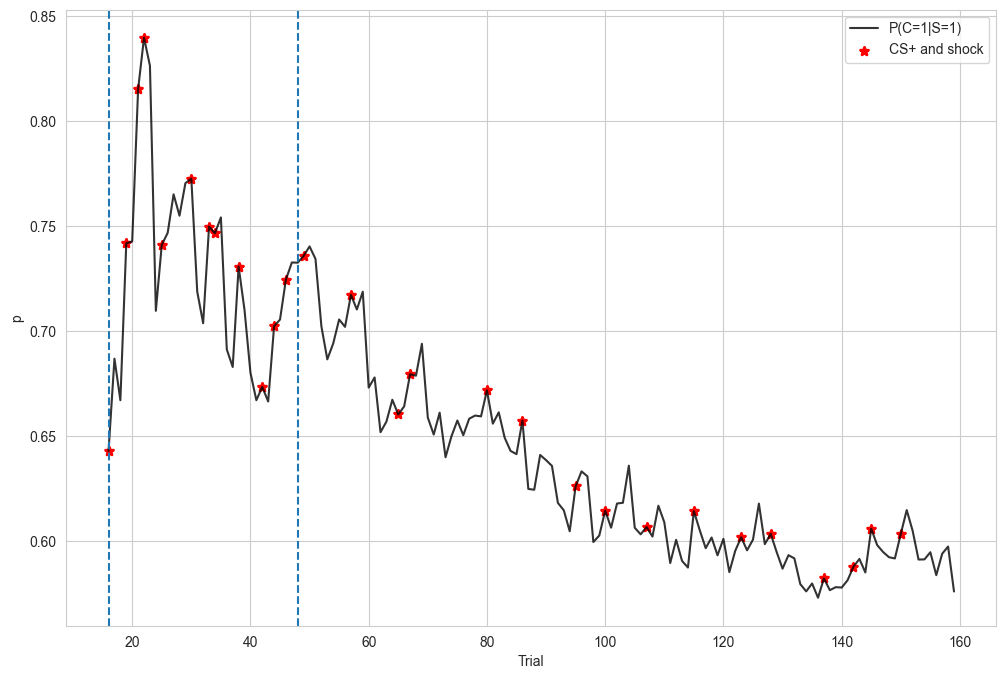

In [10]:
all_means = np.array(all_means)
# all 144 trials
X = np.arange(16, 16+len(all_means))
y = all_means[:, 1, 1]

# only simulated training trials
X_training = np.arange(16, 48)
y_training = all_means[:32, 1, 1]

# points with observation [1 1]
list_ = []
for index, i in enumerate(data_all):
    if np.equal(i, np.array([1,1])).all():
        list_.append(np.array([X[index], y[index]]))
x_points, y_points = np.array(list_)[:,0], np.array(list_)[:,1]

fig = plt.figure(figsize=(12,8))

plt.plot(X, y, label='P(C=1|S=1)', color = 'black', alpha=0.8)
plt.scatter(x_points, y_points, marker='*', color='red', linewidths=2, label='CS+ and shock')
plt.ylabel('p')
plt.xlabel('Trial')
plt.legend()
plt.axvline(x=48, linestyle='--')
plt.axvline(x=16, linestyle='--')
plt.show()

In [11]:
array_csplus = []
array_csminus = []
for index, data in enumerate(data_all):
    if data[0] == 1:
        array_csplus.append([X[index], all_means[index,1,1]])
    else:
        array_csminus.append([X[index], all_means[index,0,1]])

csplus_learning = []
csminus_learning = []
total_simulated = []
for index_train, data_train in enumerate(learning_data):
    if data_train[0] == 1:
        csplus_learning.append([X_training[index_train], all_means[index_train,1,1]])
        total_simulated.append(all_means[index_train,1,1])
    else:
        csminus_learning.append([X_training[index_train], all_means[index_train,0,1]])
        total_simulated.append(all_means[index_train,0,1])

total_simulated = np.array(total_simulated)
array_csplus = np.array(array_csplus)
array_csminus = np.array(array_csminus)
csplus_learning = np.array(csplus_learning)
csminus_learning = np.array(csminus_learning)

In [12]:
df_ = df[['shock', 'rating', 'morphing level']]
df_['shock'] = df_['shock'].astype(int)
df_['morphing level'] = [int(d == 6) for d in df_['morphing level']]
df_['rating'] = df_['rating'].replace([1, 2, 3, 4, 5], [0.2, 0.4, 0.6, 0.8, 1])

/var/folders/hn/nq1_cby521sbf58lnj9qj9mw0000gn/T/ipykernel_4127/4112460405.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['shock'] = df_['shock'].astype(int)
/var/folders/hn/nq1_cby521sbf58lnj9qj9mw0000gn/T/ipykernel_4127/4112460405.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['morphing level'] = [int(d == 6) for d in df_['morphing level']]
/var/folders/hn/nq1_cby521sbf58lnj9qj9mw0000gn/T/ipykernel_4127/4112460405.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

In [13]:
df_new=df_[16:]
df_learning = df_[16:48]
df_learning

,shock,rating,morphing level
16,1,0.2,1
17,0,0.4,0
18,0,0.4,0
19,1,0.4,1
20,0,0.4,0
21,1,0.6,1
22,1,0.8,1
23,0,0.2,0
24,0,0.8,1
25,1,0.8,1


In [14]:
y_plus_real = df_new.loc[df_new['morphing level']==1].rating.values
x_plus_real = np.array(df_new.loc[df_new['morphing level']==1].index)
y_minus_real = df_new.loc[df_new['morphing level']==0].rating.values
x_minus_real = np.array(df_new.loc[df_new['morphing level']==0].index)
y_real=df_new.rating.values

y_plus_train = df_learning.loc[df_learning['morphing level']==1].rating.values
x_plus_train = np.array(df_learning.loc[df_learning['morphing level']==1].index)
y_minus_train = df_learning.loc[df_learning['morphing level']==0].rating.values
x_minus_train = np.array(df_learning.loc[df_learning['morphing level']==0].index)
y_train=df_learning.rating.values

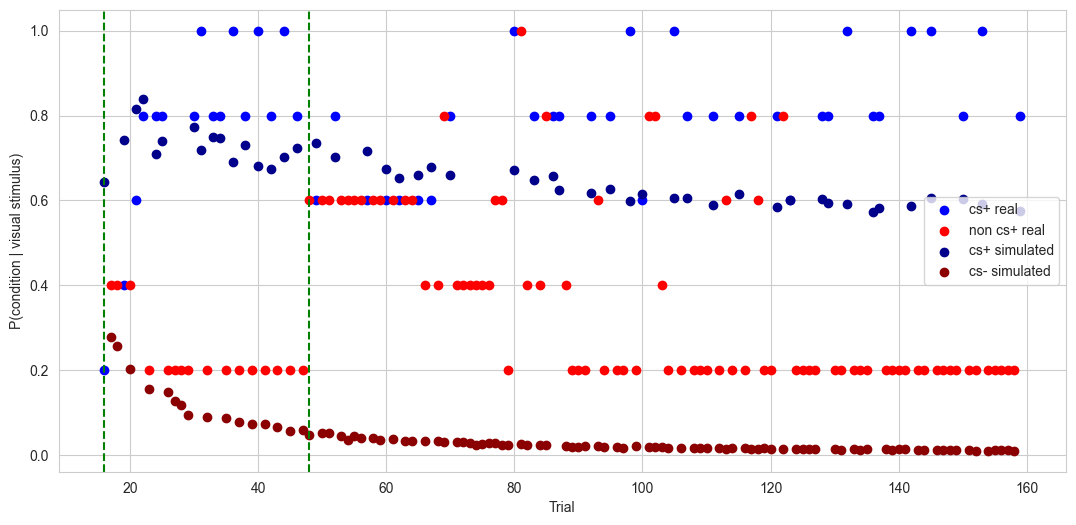

In [15]:
fig = plt.figure(figsize=(13,6))
plt.scatter(x_plus_real, y_plus_real, color='blue', label='cs+ real')
plt.scatter(x_minus_real, y_minus_real, color='red', label='non cs+ real')
plt.scatter(array_csplus[:,0], array_csplus[:,1], color='darkblue', label='cs+ simulated')
plt.scatter(array_csminus[:,0], array_csminus[:,1], color='darkred', label='cs- simulated')
plt.legend(loc='right')
plt.axvline(x=16, linestyle='--', color='green')
plt.axvline(x=48, linestyle='--', color='green')
plt.xlabel('Trial')
plt.ylabel('P(condition | visual stimulus)')
plt.show()

In [16]:
print(len(y_minus_train), len(csminus_learning[:,1]))

16 16


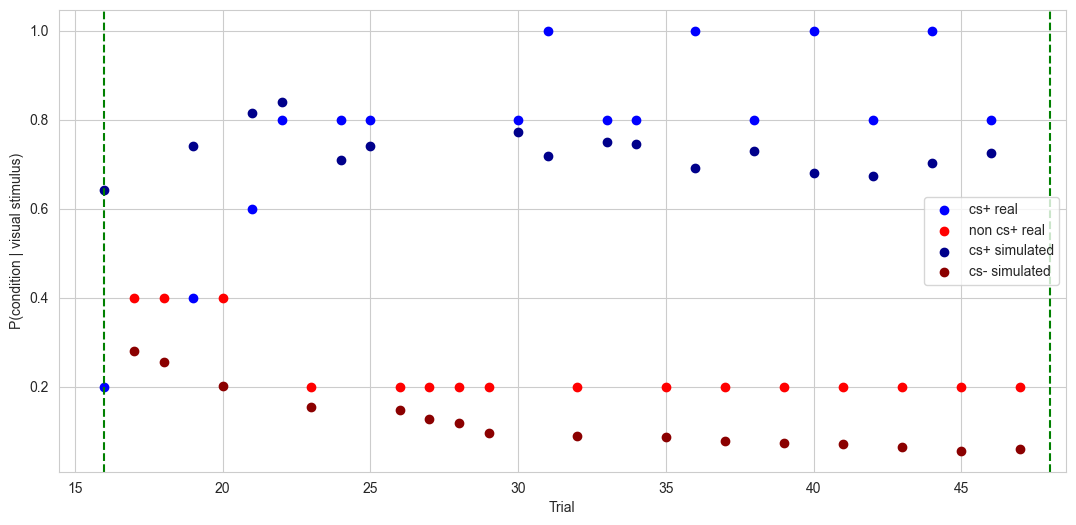

In [17]:
fig2 = plt.figure(figsize=(13,6))
plt.scatter(x_plus_train, y_plus_train, color='blue', label='cs+ real')
plt.scatter(x_minus_train, y_minus_train, color='red', label='non cs+ real')
plt.scatter(csplus_learning[:,0], csplus_learning[:,1], color='darkblue', label='cs+ simulated')
plt.scatter(csminus_learning[:,0], csminus_learning[:,1], color='darkred', label='cs- simulated')
plt.legend(loc='right')
plt.axvline(x=16, linestyle='--', color='green')
plt.axvline(x=48, linestyle='--', color='green')
plt.xlabel('Trial')
plt.ylabel('P(condition | visual stimulus)')
plt.show()
plt.show()

In [22]:
np.corrcoef(y_train,total_simulated)

array([[1.        , 0.87076154],
       [0.87076154, 1.        ]])

## Deep Markov model

![example](https://pyro.ai/examples/_static/img/model.png)

In [1]:
import argparse
import logging
import time
from os.path import exists
import numpy as np
import torch
import torch.nn as nn
import pyro
import pyro.contrib.examples.polyphonic_data_loader as poly
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.distributions import TransformedDistribution
from pyro.distributions.transforms import affine_autoregressive
from pyro.infer import (
    SVI,
    JitTrace_ELBO,
    Trace_ELBO,
    TraceEnum_ELBO,
    TraceTMC_ELBO,
    config_enumerate,
)
from pyro.optim import ClippedAdam

In [3]:
# emission function (Emit in the figure)
class Emitter(nn.Module):
    """
    Parameterizes the bernoulli observation likelihood p(x_t|z_t)

    """
    def __init__(self, input_dim, z_dim, emission_dim):
        super().__init__()
        # emission_dim is the number of hidden units in the neural network
        # three linear transformations used in the neural network
        self.lin_z_to_hidden = nn.Linear(z_dim, emission_dim)
        self.lin_hidden_to_hidden = nn.Linear(emission_dim, emission_dim)
        self.lin_hidden_to_input = nn.Linear(emission_dim, input_dim)
        # two non linear used in the neural network
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, z_t):
        """
        Given the latent z at a particular time step t, we return the vector of probabilities 'ps' that parametrizes the bernoulli distribution p(x_t|z_t)
        Taken together the elements of ps encode which notes we expect to observe at time t given the state of the system (as encoded in z_t).
        """
        h1 = self.relu(self.lin_z_to_hidden(z_t))
        h2 = self.relu(self.lin_hidden_to_hidden(h1))
        ps = self.sigmoid(self.lin_hidden_to_input(h2))
        return ps

In [4]:
# gated transition (Trans in the figure above)
class GatedTransition(nn.Module):
    """
    Parameterizes the gaussian latent transition probability p(z_t | z_{t-1})
    """
    def __init__(self, z_dim, transition_dim):
        super().__init__()
        # six linear transform
        self.lin_gate_z_to_hidden = nn.Linear(z_dim, transition_dim)
        self.lin_gate_hidden_to_z = nn.Linear(transition_dim, z_dim)
        self.lin_proposed_mean_z_to_hidden = nn.Linear(z_dim, transition_dim)
        self.lin_proposed_mean_hidden_to_z = nn.Linear(transition_dim, z_dim)
        self.lin_sig = nn.Linear(z_dim, z_dim)
        self.lin_z_to_loc = nn.Linear(z_dim, z_dim)

        # modify the default initialization of lin_z_to_loc
        # so that it's starts out as the IDENTITY FUNCTION
        self.lin_z_to_loc.weight.data = torch.eye(z_dim)
        self.lin_z_to_loc.bias.data = torch.zeros(z_dim)

        # three non linear
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.softplus = nn.Softplus()


    def forward(self, z_t_1):
        """
        Given the latent z_{t-1} corresponding to the time step t-1 we return the mean and scale vectors that parameterize the
        (diagonal) gaussian distribution p(z_t | z_{t-1})
        """
        # compute the gating function
        _gate = self.relu(self.lin_gate_z_to_hidden(z_t_1))
        gate = self.sigmoid(self.lin_gate_hidden_to_z(_gate))

        # compute the 'proposed mean'
        _proposed_mean = self.relu(self.lin_proposed_mean_z_to_hidden(z_t_1))
        proposed_mean = self.lin_proposed_mean_hidden_to_z(_proposed_mean)

        # assemble the actual mean used to sample z_t, which mixes a linear transformation of z_{t-1} with the proposed mean
        # modulated by the gating function
        loc = (1 - gate) * self.lin_z_to_loc(z_t_1) + gate * proposed_mean

        # compute the scale used to sample z_t, using the proposed
        # mean from above as input. the softplus ensures that scale is positive
        scale = self.softplus(self.lin_sig(self.relu(proposed_mean)))

        # return loc, scale which can be fed into Normal (mean and covariance of our Gaussian)
        return loc, scale

In [ ]:
# simple model (not working)
def model(...):
    # initializer
    z_prev = self.z_0

    # sample the latents z and observed x's one time step at a time
    for t in range(1, T_max + 1):
        # the next two lines of code sample z_t ~ p(z_t | z_{t-1}).
        # first compute the parameters of the diagonal gaussian
        # distribution p(z_t | z_{t-1})
        z_loc, z_scale = self.trans(z_prev)
        # then sample z_t according to dist.Normal(z_loc, z_scale)
        z_t = pyro.sample("z_%d" % t, dist.Normal(z_loc, z_scale))

        # compute the probabilities that parameterize the bernoulli likelihood
        emission_probs_t = self.emitter(z_t)
        # the next statement instructs pyro to observe x_t according to the
        # bernoulli distribution p(x_t|z_t)
        pyro.sample("obs_x_%d" % t,
                    dist.Bernoulli(emission_probs_t),
                    obs=mini_batch[:, t - 1, :])
        # the latent sampled at this time step will be conditioned upon
        # in the next time step so keep track of it
        z_prev = z_t

### Agent example

In [12]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import Trace_ELBO, SVI


def transition_model(state):
    p_stay = 0.7 if state else 0.9
    p_switch = 1 - p_stay
    return pyro.sample('state_transition', dist.Categorical(torch.tensor([p_stay, p_switch])))


def emission_model(state):
    p_emission = 0.9 if state else 0.1
    return pyro.sample('emission', dist.Bernoulli(torch.tensor(p_emission)))


def initial_model():
    return pyro.sample('initial_state', dist.Categorical(torch.tensor([0.5, 0.5])))


def model(stimuli, shock, initial_state):
    states = [pyro.sample('init_state', dist.Categorical(initial_state))]
    emissions = [emission_model(states[0]).item()]
    for i in range(1, len(stimuli)):
        states.append(transition_model(states[i-1]).item())
        emissions.append(emission_model(states[i]).item())
    return states, emissions


def guide(stimuli, shock, initial_state, states, emissions):
    for i in range(len(stimuli)):
        states[i] = pyro.sample('state_{}'.format(i), dist.Bernoulli(torch.tensor(0.5)))
        emissions[i] = pyro.sample('emission_{}'.format(i), dist.Bernoulli(torch.tensor(0.5)))


stimuli = torch.tensor([0, 0, 0, 1, 1, 0, 1, 1, 0])
shock = torch.tensor([0, 0, 0, 1, 1, 0, 0, 1, 0])
initial_state = torch.tensor([0.5, 0.5])

optimizer = pyro.optim.Adam({'lr': 0.1})
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

for i in range(1000):
    states, emissions = model(stimuli, shock, initial_state)
    loss = svi.step(stimuli, shock, initial_state, states, emissions)
    if i % 100 == 0:
        print("step {}: loss = {}".format(i, loss))


TypeError: model() takes 3 positional arguments but 5 were given